# Решение домашнего задания #5

Для решения будем использовать Mamba модель из простой имплементации на торче (https://github.com/myscience/mamba), однако немного упрощена для большей компактности.

### Базовая настройка

In [1]:
from mamba import LLMMamba, MambaConfig

import torch
from torch.utils.data import DataLoader

from lightning.pytorch import Trainer, LightningModule

from transformers import GPT2Tokenizer

import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

/home/setday/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.set_float32_matmul_precision('medium')

In [3]:
TARGET_ROW = "To prove that"

In [ ]:
config = MambaConfig(
    vocab_size=50304,
    num_layers=12,
    d_input=64,
    d_model=64,
    d_state=64,
    ker_size=7,
    d_discr=64,
    parallel=True
)

### Загрузка датасета (датасет латеховских статей) и токенайзера (токенайзер GPT-2)

In [5]:
train_ds = pd.concat([pd.read_parquet(f'../../data/proof-pile/000{i}.parquet') for i in range(3)], ignore_index=True)
text_data = train_ds['text'].tolist()

In [6]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.add_special_tokens({'pad_token': '<|pad|>'})

1

### Теперь нам нужен кастомный лоадер для тренировки

In [7]:
class CustomLoader(DataLoader):
    def __init__(self, texts, tokenizer, loader_size=16, batch_size=16, block_size=128):
        self.texts = texts
        self.tokenizer = tokenizer
        self.batch_size = batch_size
        self.block_size = block_size
        self.loader_size = loader_size

        self.text_id = -self.loader_size
        self.page_tokens = None
        self.page_training_pairs = None

        self.next_page()

        super().__init__(self, batch_size=batch_size)

    def next_page(self):
        self.text_id += self.loader_size
        if self.text_id + self.loader_size > len(self.texts):
            self.text_id = 0
        self.page_tokens = [
            self.tokenizer.encode(self.texts[self.text_id + i])
            for i in range(self.loader_size)
        ]
        self.page_training_pairs = torch.tensor([
            [
                tokens[i:i + self.block_size],
                tokens[i + 1:i + self.block_size + 1]
            ]
            for tokens in self.page_tokens
            for i in range(0, len(tokens) - self.block_size)
        ])
        self.page_training_pairs = self.page_training_pairs[torch.randperm(len(self.page_training_pairs))]

    def __iter__(self):
        for i in range(0, len(self.page_training_pairs), self.batch_size * 30):
            yield self.page_training_pairs[i:i + self.batch_size, 0, :], self.page_training_pairs[i:i + self.batch_size, 1, :]

    def __len__(self):
        return len(self.page_training_pairs) // self.batch_size // 30

### Теперь мы готовы к обучению

In [8]:
dl = CustomLoader(text_data, tokenizer)

Token indices sequence length is longer than the specified maximum sequence length for this model (7399 > 1024). Running this sequence through the model will result in indexing errors


In [9]:
class LightningMamba(LightningModule):
    def __init__(self, config, tokenizer):
        super().__init__()
        self.model = LLMMamba(config)
        self.tokenizer = tokenizer

        self.loss_history = []

    def forward(self, idx, targets=None):
        logits, loss = self.model(idx, targets)
        return logits, loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=3e-4, eps=1e-8, betas=(0.9, 0.95), fused=True)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer, T_0=10, T_mult=2, eta_min=1e-5
        )
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'interval': 'epoch',
                'frequency': 1,
            }
        }
    
    def training_step(self, batch, batch_idx):
        idx, targets = batch
        loss = self.model.compute_loss(idx, targets)
        self.log('train/loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=False)
        self.loss_history.append(loss.item())
        return loss
    
    def on_train_epoch_start(self):
        seg_generator = self.model.generate(
            prompt=TARGET_ROW,
            tokenizer=self.tokenizer,
            token_lim=10,
            use_top_k=10
        )
        generated_text = "".join([seg[0] for seg in seg_generator])
        print('test/generated_text', generated_text)
        
        return super().on_train_epoch_start()
    
    def on_train_epoch_end(self):
        dl.next_page()

        return super().on_train_epoch_end()

In [10]:
model = LightningMamba(config, tokenizer)

In [11]:
trainer = Trainer(
    max_epochs=10,
    accelerator="auto",
    enable_progress_bar=True,
    logger=False,
    enable_checkpointing=False,
)
trainer.fit(model, train_dataloaders=dl)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type     | Params | Mode 
-------------------------------------------
0 | model | LLMMamba | 20.7 M | train
-------------------------------------------
20.7 M    Trainable params
0         Non-trainable params
20.7 M    Total params
82.876    Total estimated model params size (MB)
268       Modules in train mode
0         Modules in eval mode
c:\Users\setday\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

test/generated_text To prove that plantation everybody Binary justiceskan Houth Corinthians SECTION McCull conclusion
test/generated_text To prove that process$ means built propose nowigmaint quoteps
test/generated_text To prove that\ge of 7 the proof}\label}\text
test/generated_text To prove that $(indent\,
\textsilon
test/generated_text To prove that}) as Thena of$ in generalL\
test/generated_text To prove that $$5y $ \ note.} with the
test/generated_text To prove that ifB_ge (\_\inr
test/generated_text To prove thatA(\ = \item \emph 4i
test/generated_text To prove that wecaltau[:0u that a
test/generated_text To prove that if \quad}(\ilde\end definition of


`Trainer.fit` stopped: `max_epochs=10` reached.


<Axes: >

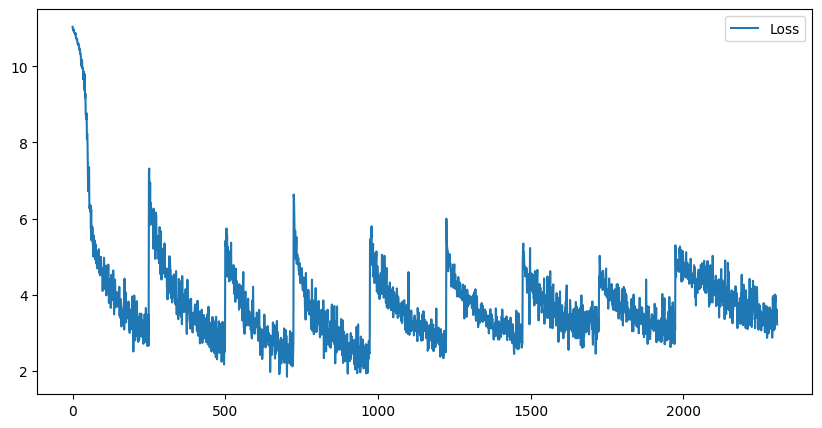

In [12]:
plt.figure(figsize=(10, 5))
sns.lineplot(x=range(len(model.loss_history)), y=model.loss_history, label='Loss')

### Смотрим, что же получилось

_предварительно откатываем модель до 3-ей эпохи_

In [13]:
generated_text = "".join([tok[0] for tok in model.model.generate(
    TARGET_ROW,
    tokenizer=tokenizer,
    token_lim=300,
    use_top_k=10
)])
print('test/generated_text', generated_text)

test/generated_text To prove that we.==1},H\$ by \^{\T \sumin of wee.}-B1}(ii that satisfies from we can 1 with some=beta+1{
  Let= is a result(S:CA}(4_{. Let \ref}\tR[-0-v, then bybeta for and \emph{Gl:d .
theta_RT (rr~s{x\Nint set that it is $L an Gc$, respectivelyem+ the existenceqjoint = $(e:3M $v}\label} byg is to \begin{ and has<^(5\end and (s-1 $},{cor:25muv+L},P}\bigs^{iH,j1_1(ii $\$ for}


a.}_{. There and a constant). Ad--F:, which implies=mhspace such\fracU,
$$ and it and in $\:K[sub used \times
1\:=Zin then-{G11x \frac{S}
\$, a} and the only if the)\ and using':h73}\^{1+),frho, withma^s (\= does obtain a})=Aeqp
 Theorem_. Av, a})_a as anfQ


In [14]:
def plot_weights(weights, title='Attention Weights'):
    fig, ax = plt.subplots(3, 4, figsize=(12, 6))
    fig.suptitle(title, fontsize=16)

    for i in range(weights.shape[0]):
        sns.heatmap(weights[i].detach().cpu().numpy(), ax=ax[i // 4][i % 4], square=True)
        ax[i // 4][i % 4].set_title(f'Head {i+1}')
        ax[i // 4][i % 4].axis('off')

    plt.tight_layout()
    plt.show()

In [15]:
plot_weights(model.model.transformer.h[0].saved_head_weight[0], title='Attention Weights - Layer 0')
plot_weights(model.model.transformer.h[6].saved_head_weight[0], title='Attention Weights - Layer 6')
plot_weights(model.model.transformer.h[-1].saved_head_weight[0], title='Attention Weights - Last Layer')

AttributeError: 'LLMMamba' object has no attribute 'transformer'

# Итоги

1. Модель довольно быстро обучилась на корпусе научных статей (`за 3 эпохи`). Это связано с тем, что в ней весьма мало параметров (`15 M`), равно как и мало контекстное окно (`128 токенов`). Дальше наинает происходить уже переобучение, которое легко заметить по повторяющимся токенам.
2. График потерь имеет весбма странную тенденцию: в начале он явно опускается, но начиная с `4-ой` эпохи потери начинают расти (по нижней границе). Это могло бы свидетельствовать о переобучении, однако на `4-ой` эпохе модель также выдавала весьма сомнительные результаты.
3. Интересная ситуация происходит и с головами: головы первого уровня распыляют своё внимание на весь контекст, тогда как ближе к концу у нас уже соединяются отдельные конструкции (отдельные токены). При переобучении (на `10 эпохе`) все головы выглядят почти одинаково - внимание только на первых токенах, что очень легко объясняет то, почему модель начинает повторяться.

|                           | Mamba    | GPT         | MambaPy   | 
|---------------------------|----------|-------------|-----------|
| Training time             | 11m 4,0s | **3m 4.2s** | 10m 23.0s |
| 300 token generation time | 10.1     | 9.5s        | **5.3s**  |
| Size                      | 20.7 M   | 15.0 M      | **7.1 M** |
| Quality                   | 1/5      | 4/5         | 4/5       |

4. Дополнительно был проведен эксперимент на библиотеке MambaPyб которая имеет уже реализованную архитектуру. Её качество оказалось 